# look at differences in contam removal when using different databases to decontam the simulated genomes 

In [1]:
setwd("..")

In [2]:
# disable scientific notation (for plot axes)
options(scipen = 999)

In [3]:
# change default figure size
options(repr.plot.width=7, repr.plot.height=4, repr.plot.res = 300)

In [5]:
library(dplyr)
library(readr)
library(tidyr)
library(purrr)
library(rentrez)
library(ggplot2)
library(ggpubr)
library(ComplexUpset)
library(janitor)
library(jsonlite)
library(tibble)
library(stringr)

## functions

In [6]:
read_contigs_tax <- function(contigs_tax_path){  
  json <- fromJSON(contigs_tax_path)
  contig_tax_all <- data.frame()
  for(i in 1:length(json)){
    contig_name <- names(json)[i]
    basepairs <- json[[i]][[1]]
    hashes <- json[[i]][[2]]
    if(length(json[[i]][[3]]) > 0){
      lineage <- json[[i]][[3]][[1]][[1]][,2]
      lineage = paste(lineage, collapse = ";", sep = ";")
      matched_hashes <- json[[i]][[3]][[1]][[2]]
    } else {
      lineage = NA
      matched_hashes = NA
    }
    contig_tax <- data.frame(contig_name, basepairs, hashes, lineage, matched_hashes)
    contig_tax_all <- bind_rows(contig_tax_all, contig_tax)
  }
   contig_tax_all$genome <- gsub(".contigs-tax.json", "", basename(contigs_tax_path))
   return(contig_tax_all)
}

## read in GTDB rs207 metadata

just use rs207 lineage designations. don't want to deal with book keeping between the two, when it probably wouldn't matter any way.

In [7]:
gtdb_metadata_rs207 <- read_tsv("inputs/gtdb-rs207/bac120_metadata_r207.tsv", show_col_types = FALSE) %>%
  #separate(gtdb_taxonomy, into = c("domain", "phylum", "class", "order", "family", "genus", "species"), 
  #         sep = ";") %>%
  mutate(ncbi_database = ifelse(grepl(pattern = "GB", accession), "GenBank", "none"),
         ncbi_database = ifelse(grepl(pattern = "RS", accession), "RefSeq", ncbi_database)) %>%
  mutate(accession = gsub("^RS_", "", accession),
         accession = gsub("^GB_", "", accession),
         accession_pruned = gsub("GC[FA]_", "", accession),
         accession_pruned = gsub("\\..", "", accession_pruned))

gtdb_metadata_rs207 <- read_tsv("inputs/gtdb-rs207/ar53_metadata_r207.tsv", show_col_types = FALSE) %>%
  #separate(gtdb_taxonomy, into = c("domain", "phylum", "class", "order", "family", "genus", "species"), 
  #         sep = ";") %>%
  mutate(ncbi_database = ifelse(grepl(pattern = "GB", accession), "GenBank", "none"),
         ncbi_database = ifelse(grepl(pattern = "RS", accession), "RefSeq", ncbi_database)) %>%
  mutate(accession = gsub("^RS_", "", accession),
         accession = gsub("^GB_", "", accession),
         accession_pruned = gsub("GC[FA]_", "", accession),
         accession_pruned = gsub("\\..", "", accession_pruned)) %>%
  bind_rows(gtdb_metadata_rs207)

Warning message:
“One or more parsing issues, see `problems()` for details”


## read in and parse faidx files; join to other metadata information

file names contain info on whether charcoal decided a contig was clean or dirty.
faidx contains info on contig name and genome origin.


In [8]:
# faidx colname legend
# NAME	Name of this reference sequence
# LENGTH	Total length of this reference sequence, in bases
# OFFSET	Offset in the FASTA/FASTQ file of this sequence's first base
# LINEBASES	The number of bases on each line
# LINEWIDTH	The number of bytes in each line, including the newline
# QUALOFFSET	Offset of sequence's first quality within the FASTQ file

faidx <- Sys.glob("sandbox/gunc_synthetic_genomes3b/type3b.genomes/outputs/*/*fai") %>%
  set_names() %>%
  map_dfr(read_tsv, show_col_types = F, col_names = c("contig_name", "length", "offset", "linebases", "linewidth", "qualoffset"), .id = "filename") %>%
  mutate(type = ifelse(grepl("clean", x = filename), "clean", "dirty"),
         database = ifelse(grepl("rs207_reps", x = filename), "gtdb rs207 reps", 
                          ifelse(grepl("rs207_full", x = filename), "gtdb rs207 full",
                                ifelse(grepl("rs202_full", x = filename), "gtdb rs202 full", "gtdb rs202 reps"))),
         genome = gsub("_\\.fa.*", "", basename(filename))) %>%
  select(genome, database, type, contig_name, length) %>%
  separate(contig_name, into = c("num", "genome_accession", "contig"), sep = "\\.")

In [9]:
# join to contam level (as inferred from GTDB)
gtdb_contamination_level <- read_tsv("sandbox/gunc_synthetic_genomes3b/type3b.genomes/genome_contamination_level.tsv", show_col_type = F)

faidx <- faidx %>%
  left_join(gtdb_contamination_level, by = c("genome"))

In [10]:
# join to gather lineage info, which sets dominant lineage (e.g. which was set as the genome and which was set as contam)
lineages_rs207 <- read_csv("sandbox/gunc_synthetic_genomes3b/type3b.genomes/genomes_to_charcoal3_rs207_lineages.csv", show_col_types = F) %>%
  mutate(dom_lineage = paste(superkingdom, phylum, class, order, family, genus, species, sep = ";")) %>%
  mutate(ident = gsub("_\\.fa", "", ident)) %>%
  select(ident, dom_lineage)

faidx <- faidx %>%
  left_join(lineages_rs207, by = c("genome" = "ident"))

In [11]:
# convert biosample ID to genbank/refseq accession
biosample_to_assembly_df <- data.frame()
for(biosample_accession in unique(faidx$genome_accession)){
    tmp_search <- entrez_search(db="assembly", term= biosample_accession) # search for the id assoc with this record
    tmp_summary <- entrez_summary(db="assembly", id=tmp_search$id)        # use id to retrieve info about accession
    if(length(tmp_summary) > 5){ # assemblies with multiple accessions will have nested lists, with the first list being shallow
        assembly_accession <- tmp_summary$assemblyaccession               # extract assembly accession
        tmp_biosample_to_assembly_df <- data.frame(biosample = biosample_accession, assembly = assembly_accession) # make temp df 
        biosample_to_assembly_df <- bind_rows(biosample_to_assembly_df, tmp_biosample_to_assembly_df) # bind to final results
    } else {
        assembly_accession <- tmp_summary[[1]]$assemblyaccession          # extract assembly accession
        tmp_biosample_to_assembly_df <- data.frame(biosample = biosample_accession, assembly = assembly_accession) # make temp df 
        biosample_to_assembly_df <- bind_rows(biosample_to_assembly_df, tmp_biosample_to_assembly_df) # bind to final results
    }
}

In [12]:
# join to gtdb metadata information to label each contig with a lineage
faidx <- faidx %>%
  left_join(biosample_to_assembly_df, by = c("genome_accession" = "biosample")) %>%
  mutate(assembly_pruned =  gsub("GC[AF]_", "", assembly),
         assembly_pruned = gsub("\\..", "", assembly_pruned)) %>%
  left_join(gtdb_metadata_rs207, by = c("assembly_pruned" = "accession_pruned")) %>%
  rename(contig_lineage = gtdb_taxonomy)

In [13]:
# label each contig as correct lineage or contaminant
faidx <- faidx %>%
  mutate(genome_type = ifelse(dom_lineage == contig_lineage, "genome", "contaminant")) %>%
  mutate(contam_type_vs_genome_type = paste0(genome_type, "_", type))

In [14]:
head(faidx)

genome,database,type,num,genome_accession,contig,length,contamination_level,gtdb_contamination_level,dom_lineage,⋯,ssu_silva_blast_perc_identity,ssu_silva_blast_subject_id,ssu_silva_taxonomy,total_gap_length,trna_aa_count,trna_count,trna_selenocysteine_count,ncbi_database,genome_type,contam_type_vs_genome_type
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
type3b_class_3_0.33_0000_1121877.SAMN02745886,gtdb rs202 full,clean,2014,SAMN05162553,CP017965_4086793-4089890,3097,class,class,d__Bacteria;p__Actinobacteriota;c__Acidimicrobiia;o__Acidimicrobiales;f__Acidimicrobiaceae;g__Ferrimicrobium;s__Ferrimicrobium acidiphilum,⋯,100,CP017965.193676.195216,Bacteria;Actinobacteriota;Actinobacteria;Streptosporangiales;Nocardiopsaceae;Nocardiopsis;Nocardiopsis dassonvillei,0,20,58,0,RefSeq,contaminant,contaminant_clean
type3b_class_3_0.33_0000_1121877.SAMN02745886,gtdb rs202 full,clean,2014,SAMN05162553,CP017965_3599354-3601472,2118,class,class,d__Bacteria;p__Actinobacteriota;c__Acidimicrobiia;o__Acidimicrobiales;f__Acidimicrobiaceae;g__Ferrimicrobium;s__Ferrimicrobium acidiphilum,⋯,100,CP017965.193676.195216,Bacteria;Actinobacteriota;Actinobacteria;Streptosporangiales;Nocardiopsaceae;Nocardiopsis;Nocardiopsis dassonvillei,0,20,58,0,RefSeq,contaminant,contaminant_clean
type3b_class_3_0.33_0000_1121877.SAMN02745886,gtdb rs202 full,clean,2014,SAMN05162553,CP017965_17879-20107,2228,class,class,d__Bacteria;p__Actinobacteriota;c__Acidimicrobiia;o__Acidimicrobiales;f__Acidimicrobiaceae;g__Ferrimicrobium;s__Ferrimicrobium acidiphilum,⋯,100,CP017965.193676.195216,Bacteria;Actinobacteriota;Actinobacteria;Streptosporangiales;Nocardiopsaceae;Nocardiopsis;Nocardiopsis dassonvillei,0,20,58,0,RefSeq,contaminant,contaminant_clean
type3b_class_3_0.33_0000_1121877.SAMN02745886,gtdb rs202 full,clean,2014,SAMN05162553,CP017965_4281971-4288572,6601,class,class,d__Bacteria;p__Actinobacteriota;c__Acidimicrobiia;o__Acidimicrobiales;f__Acidimicrobiaceae;g__Ferrimicrobium;s__Ferrimicrobium acidiphilum,⋯,100,CP017965.193676.195216,Bacteria;Actinobacteriota;Actinobacteria;Streptosporangiales;Nocardiopsaceae;Nocardiopsis;Nocardiopsis dassonvillei,0,20,58,0,RefSeq,contaminant,contaminant_clean
type3b_class_3_0.33_0000_1121877.SAMN02745886,gtdb rs202 full,clean,2014,SAMN05162553,CP017965_2560670-2563119,2449,class,class,d__Bacteria;p__Actinobacteriota;c__Acidimicrobiia;o__Acidimicrobiales;f__Acidimicrobiaceae;g__Ferrimicrobium;s__Ferrimicrobium acidiphilum,⋯,100,CP017965.193676.195216,Bacteria;Actinobacteriota;Actinobacteria;Streptosporangiales;Nocardiopsaceae;Nocardiopsis;Nocardiopsis dassonvillei,0,20,58,0,RefSeq,contaminant,contaminant_clean
type3b_class_3_0.33_0000_1121877.SAMN02745886,gtdb rs202 full,clean,2014,SAMN05162553,CP017965_4866324-4868635,2311,class,class,d__Bacteria;p__Actinobacteriota;c__Acidimicrobiia;o__Acidimicrobiales;f__Acidimicrobiaceae;g__Ferrimicrobium;s__Ferrimicrobium acidiphilum,⋯,100,CP017965.193676.195216,Bacteria;Actinobacteriota;Actinobacteria;Streptosporangiales;Nocardiopsaceae;Nocardiopsis;Nocardiopsis dassonvillei,0,20,58,0,RefSeq,contaminant,contaminant_clean


## make upset lists

In [15]:
faidx_phylum_contam_dirty <- faidx %>%
  filter(gtdb_contamination_level == "phylum") %>%
  filter(genome_type == "contaminant") %>%
  filter(type == "dirty")

In [16]:
head(faidx_phylum_contam_dirty)

genome,database,type,num,genome_accession,contig,length,contamination_level,gtdb_contamination_level,dom_lineage,⋯,ssu_silva_blast_perc_identity,ssu_silva_blast_subject_id,ssu_silva_taxonomy,total_gap_length,trna_aa_count,trna_count,trna_selenocysteine_count,ncbi_database,genome_type,contam_type_vs_genome_type
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
type3b_class_3_0.33_0000_1122947.SAMN01057329,gtdb rs202 full,dirty,1159081,SAMN02299518,KB371136_27228-31830,4602,class,phylum,d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Propionisporales;f__Propionisporaceae;g__Pelosinus;s__Pelosinus fermentans,⋯,100,FQ312042.917082.918627,Bacteria;Firmicutes;Bacilli;Lactobacillales;Streptococcaceae;Streptococcus;Streptococcus pneumoniae SPN033038,0,20,58,0,GenBank,contaminant,contaminant_dirty
type3b_class_3_0.33_0000_1122947.SAMN01057329,gtdb rs202 full,dirty,1159081,SAMN02299518,KB371125_152901-156909,4008,class,phylum,d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Propionisporales;f__Propionisporaceae;g__Pelosinus;s__Pelosinus fermentans,⋯,100,FQ312042.917082.918627,Bacteria;Firmicutes;Bacilli;Lactobacillales;Streptococcaceae;Streptococcus;Streptococcus pneumoniae SPN033038,0,20,58,0,GenBank,contaminant,contaminant_dirty
type3b_class_3_0.33_0000_1122947.SAMN01057329,gtdb rs202 full,dirty,1159081,SAMN02299518,KB371124_70808-75301,4493,class,phylum,d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Propionisporales;f__Propionisporaceae;g__Pelosinus;s__Pelosinus fermentans,⋯,100,FQ312042.917082.918627,Bacteria;Firmicutes;Bacilli;Lactobacillales;Streptococcaceae;Streptococcus;Streptococcus pneumoniae SPN033038,0,20,58,0,GenBank,contaminant,contaminant_dirty
type3b_class_3_0.33_0000_1122947.SAMN01057329,gtdb rs202 full,dirty,1159081,SAMN02299518,KB371128_0-5575,5575,class,phylum,d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Propionisporales;f__Propionisporaceae;g__Pelosinus;s__Pelosinus fermentans,⋯,100,FQ312042.917082.918627,Bacteria;Firmicutes;Bacilli;Lactobacillales;Streptococcaceae;Streptococcus;Streptococcus pneumoniae SPN033038,0,20,58,0,GenBank,contaminant,contaminant_dirty
type3b_class_3_0.33_0000_1122947.SAMN01057329,gtdb rs202 full,dirty,1159081,SAMN02299518,KB371135_19617-22526,2909,class,phylum,d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Propionisporales;f__Propionisporaceae;g__Pelosinus;s__Pelosinus fermentans,⋯,100,FQ312042.917082.918627,Bacteria;Firmicutes;Bacilli;Lactobacillales;Streptococcaceae;Streptococcus;Streptococcus pneumoniae SPN033038,0,20,58,0,GenBank,contaminant,contaminant_dirty
type3b_class_3_0.33_0000_1122947.SAMN01057329,gtdb rs202 full,dirty,1159081,SAMN02299518,KB371132_48834-51579,2745,class,phylum,d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Propionisporales;f__Propionisporaceae;g__Pelosinus;s__Pelosinus fermentans,⋯,100,FQ312042.917082.918627,Bacteria;Firmicutes;Bacilli;Lactobacillales;Streptococcaceae;Streptococcus;Streptococcus pneumoniae SPN033038,0,20,58,0,GenBank,contaminant,contaminant_dirty


In [17]:
upset_list_phylum_contam_dirty <- UpSetR::fromList(list("GTDB rs207 reps" = filter(faidx_phylum_contam_dirty, database == "gtdb rs207 reps")$contig,
                                                        "GTDB rs207 full" = filter(faidx_phylum_contam_dirty, database == "gtdb rs207 full")$contig,
                                                        "GTDB rs202 reps" = filter(faidx_phylum_contam_dirty, database == "gtdb rs202 reps")$contig,
                                                        "GTDB rs202 full" = filter(faidx_phylum_contam_dirty, database == "gtdb rs202 full")$contig))

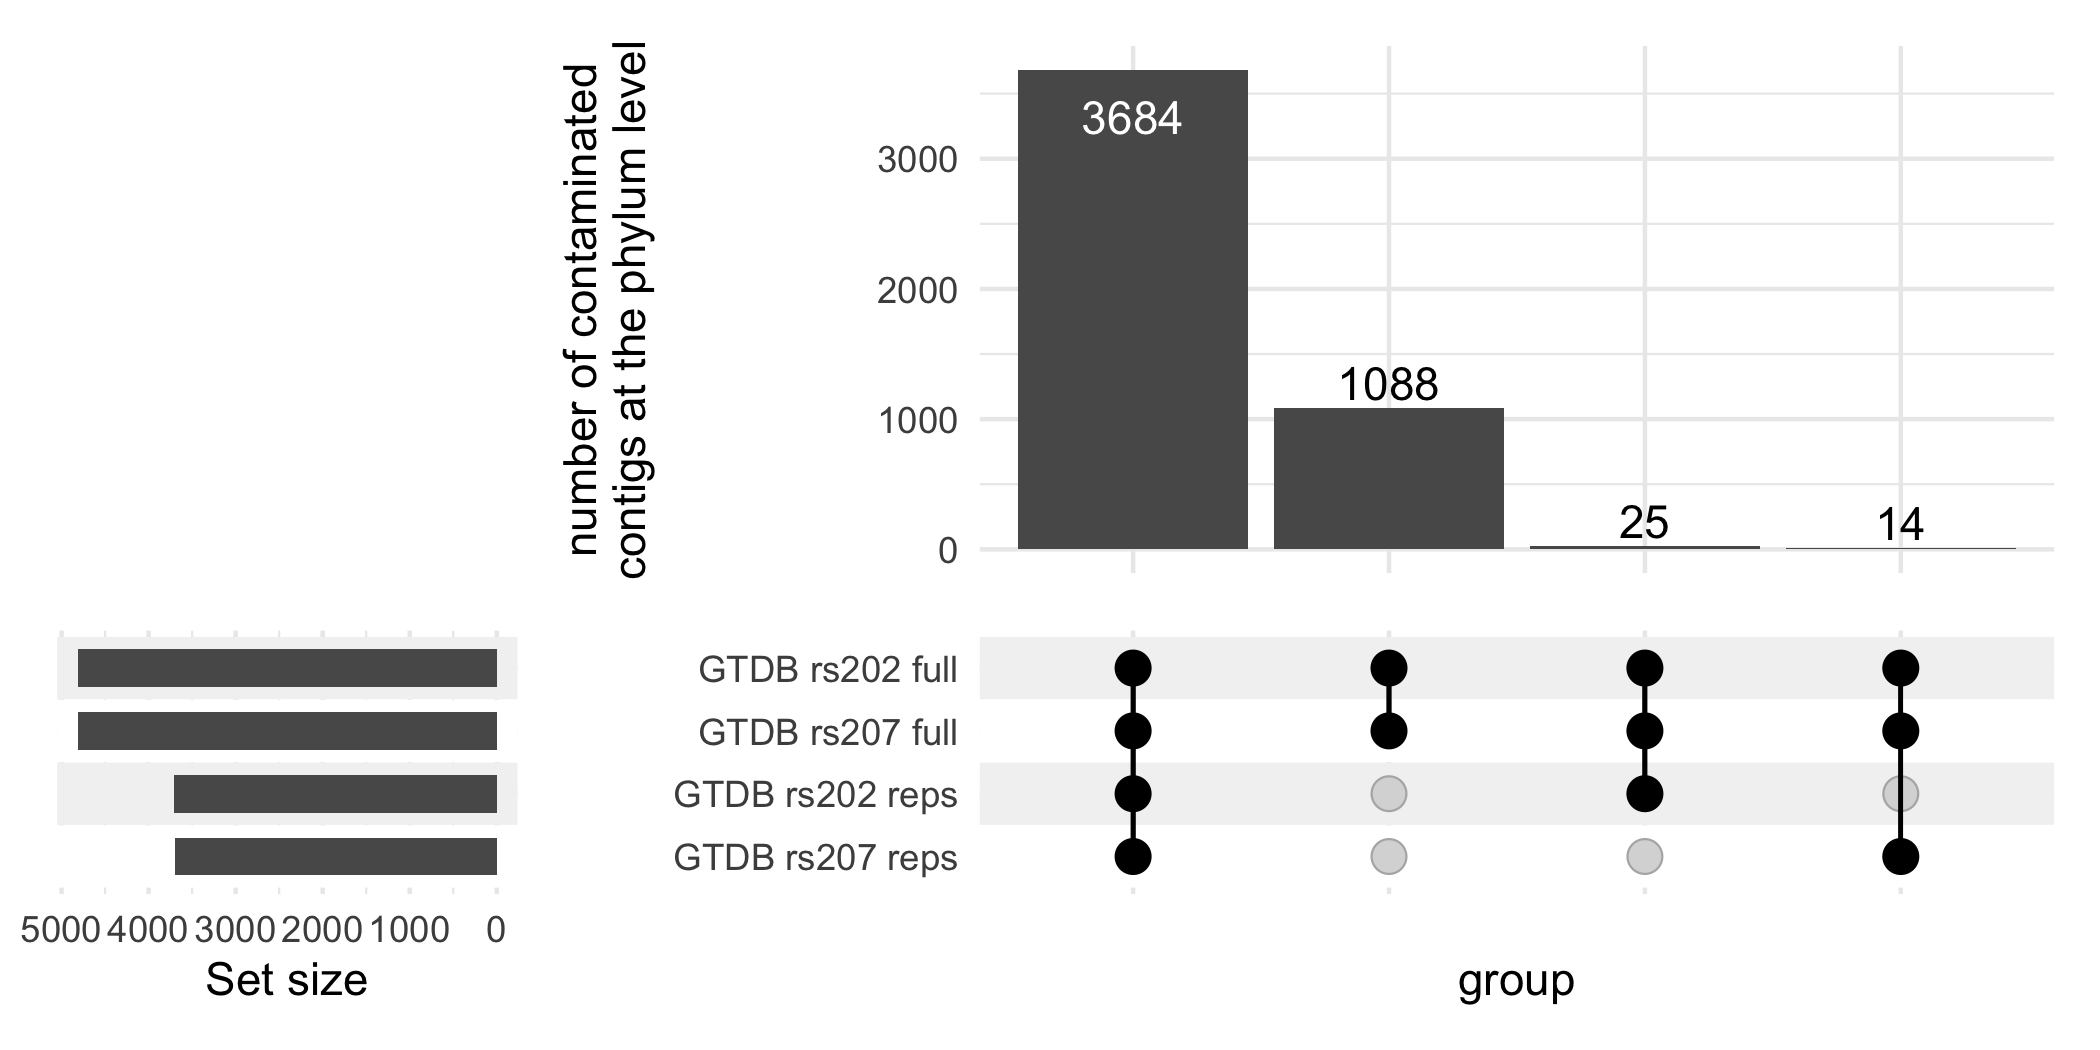

In [57]:
dbs = c("GTDB rs207 reps", "GTDB rs207 full", "GTDB rs202 reps", "GTDB rs202 full")
ComplexUpset::upset(upset_list_phylum_contam_dirty, intersect = dbs, 
                    base_annotations = list('Intersection size'=(intersection_size() + 
                                                                 ylab('number of contaminated\ncontigs at the phylum level'))))

In [19]:
table(faidx_phylum_contam_dirty$genome)


 type3b_class_3_0.33_0000_1122947.SAMN01057329 
                                           641 
 type3b_class_3_0.33_0000_1123249.SAMN02440643 
                                          1066 
 type3b_class_3_0.33_0000_1149862.SAMN01057330 
                                           882 
 type3b_class_3_0.33_0000_1160201.SAMN00811184 
                                           988 
 type3b_class_3_0.33_0000_1287313.SAMN02359689 
                                          1200 
 type3b_class_3_0.33_0000_1298595.SAMD00000528 
                                           728 
    type3b_class_3_0.33_0000_1505.SAMEA1572114 
                                           670 
type3b_phylum_3_0.33_0000_1001707.SAMN00672618 
                                           612 
type3b_phylum_3_0.33_0000_1188240.SAMN02471343 
                                           570 
    type3b_phylum_3_0.33_0000_1280.SAMEA862559 
                                          1798 
   type3b_phylum_3_0.33_0000_1280.SAMN0

## show that full database leads us to capture more contaminants in this case because more hashes are assigned to contigs

### Test single example

In [20]:
# investigate a specific genome at the contig level; look at the one with the most contaminant contigs first
# type3b_phylum_3_0.33_0000_1280.SAMEA862559
rs207_full_contig <- read_contigs_tax("sandbox/gunc_synthetic_genomes3b/type3b.genomes/outputs/genomes_to_charcoal3_vs_gtdb_rs207_full/stage1/type3b_phylum_3_0.33_0000_1280.SAMEA862559_.fa.contigs-tax.json")
rs207_rep_contig <- read_contigs_tax("sandbox/gunc_synthetic_genomes3b/type3b.genomes/outputs/genomes_to_charcoal3_vs_gtdb_rs207_reps/stage1/type3b_phylum_3_0.33_0000_1280.SAMEA862559_.fa.contigs-tax.json")

In [21]:
contig_ex <- left_join(rs207_full_contig, rs207_rep_contig, by = c("genome", "contig_name", "basepairs", "hashes")) %>%
  select(genome, contig_name, basepairs, hashes,
         matched_hashes_full = matched_hashes.x, matched_hashes_reps = matched_hashes.y,
         lineage_full = lineage.x, lineage_reps = lineage.y) %>%
  mutate(matched_hashes_full = ifelse(is.na(matched_hashes_full), 0, matched_hashes_full),
         matched_hashes_reps = ifelse(is.na(matched_hashes_reps), 0, matched_hashes_reps))

head(contig_ex)

,genome,contig_name,basepairs,hashes,matched_hashes_full,matched_hashes_reps,lineage_full,lineage_reps
,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>
1,type3b_phylum_3_0.33_0000_1280.SAMEA862559_.fa,287.SAMEA2357646.FRVO01000043_83967-86099,2132,3,3,0,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales,NA
2,type3b_phylum_3_0.33_0000_1280.SAMEA862559_.fa,287.SAMEA2357646.FRVO01000043_86099-88541,2442,1,1,0,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales,NA
3,type3b_phylum_3_0.33_0000_1280.SAMEA862559_.fa,287.SAMEA2357646.FRVO01000068_0-1180,1180,0,0,0,NA,NA
4,type3b_phylum_3_0.33_0000_1280.SAMEA862559_.fa,287.SAMEA2357646.FRVO01000077_19475-23046,3571,4,4,4,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales
5,type3b_phylum_3_0.33_0000_1280.SAMEA862559_.fa,287.SAMEA2357646.FRVO01000121_0-544,544,0,0,0,NA,NA
6,type3b_phylum_3_0.33_0000_1280.SAMEA862559_.fa,287.SAMEA2357646.FRVO01000133_167080-169165,2085,4,4,3,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales


In [22]:
head(rs207_rep_contig)

,contig_name,basepairs,hashes,lineage,matched_hashes,genome
,<chr>,<int>,<int>,<chr>,<int>,<chr>
1,287.SAMEA2357646.FRVO01000043_83967-86099,2132,3,NA,NA,type3b_phylum_3_0.33_0000_1280.SAMEA862559_.fa
2,287.SAMEA2357646.FRVO01000043_86099-88541,2442,1,NA,NA,type3b_phylum_3_0.33_0000_1280.SAMEA862559_.fa
3,287.SAMEA2357646.FRVO01000068_0-1180,1180,0,NA,NA,type3b_phylum_3_0.33_0000_1280.SAMEA862559_.fa
4,287.SAMEA2357646.FRVO01000077_19475-23046,3571,4,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales,4,type3b_phylum_3_0.33_0000_1280.SAMEA862559_.fa
5,287.SAMEA2357646.FRVO01000121_0-544,544,0,NA,NA,type3b_phylum_3_0.33_0000_1280.SAMEA862559_.fa
6,287.SAMEA2357646.FRVO01000133_167080-169165,2085,4,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales,3,type3b_phylum_3_0.33_0000_1280.SAMEA862559_.fa


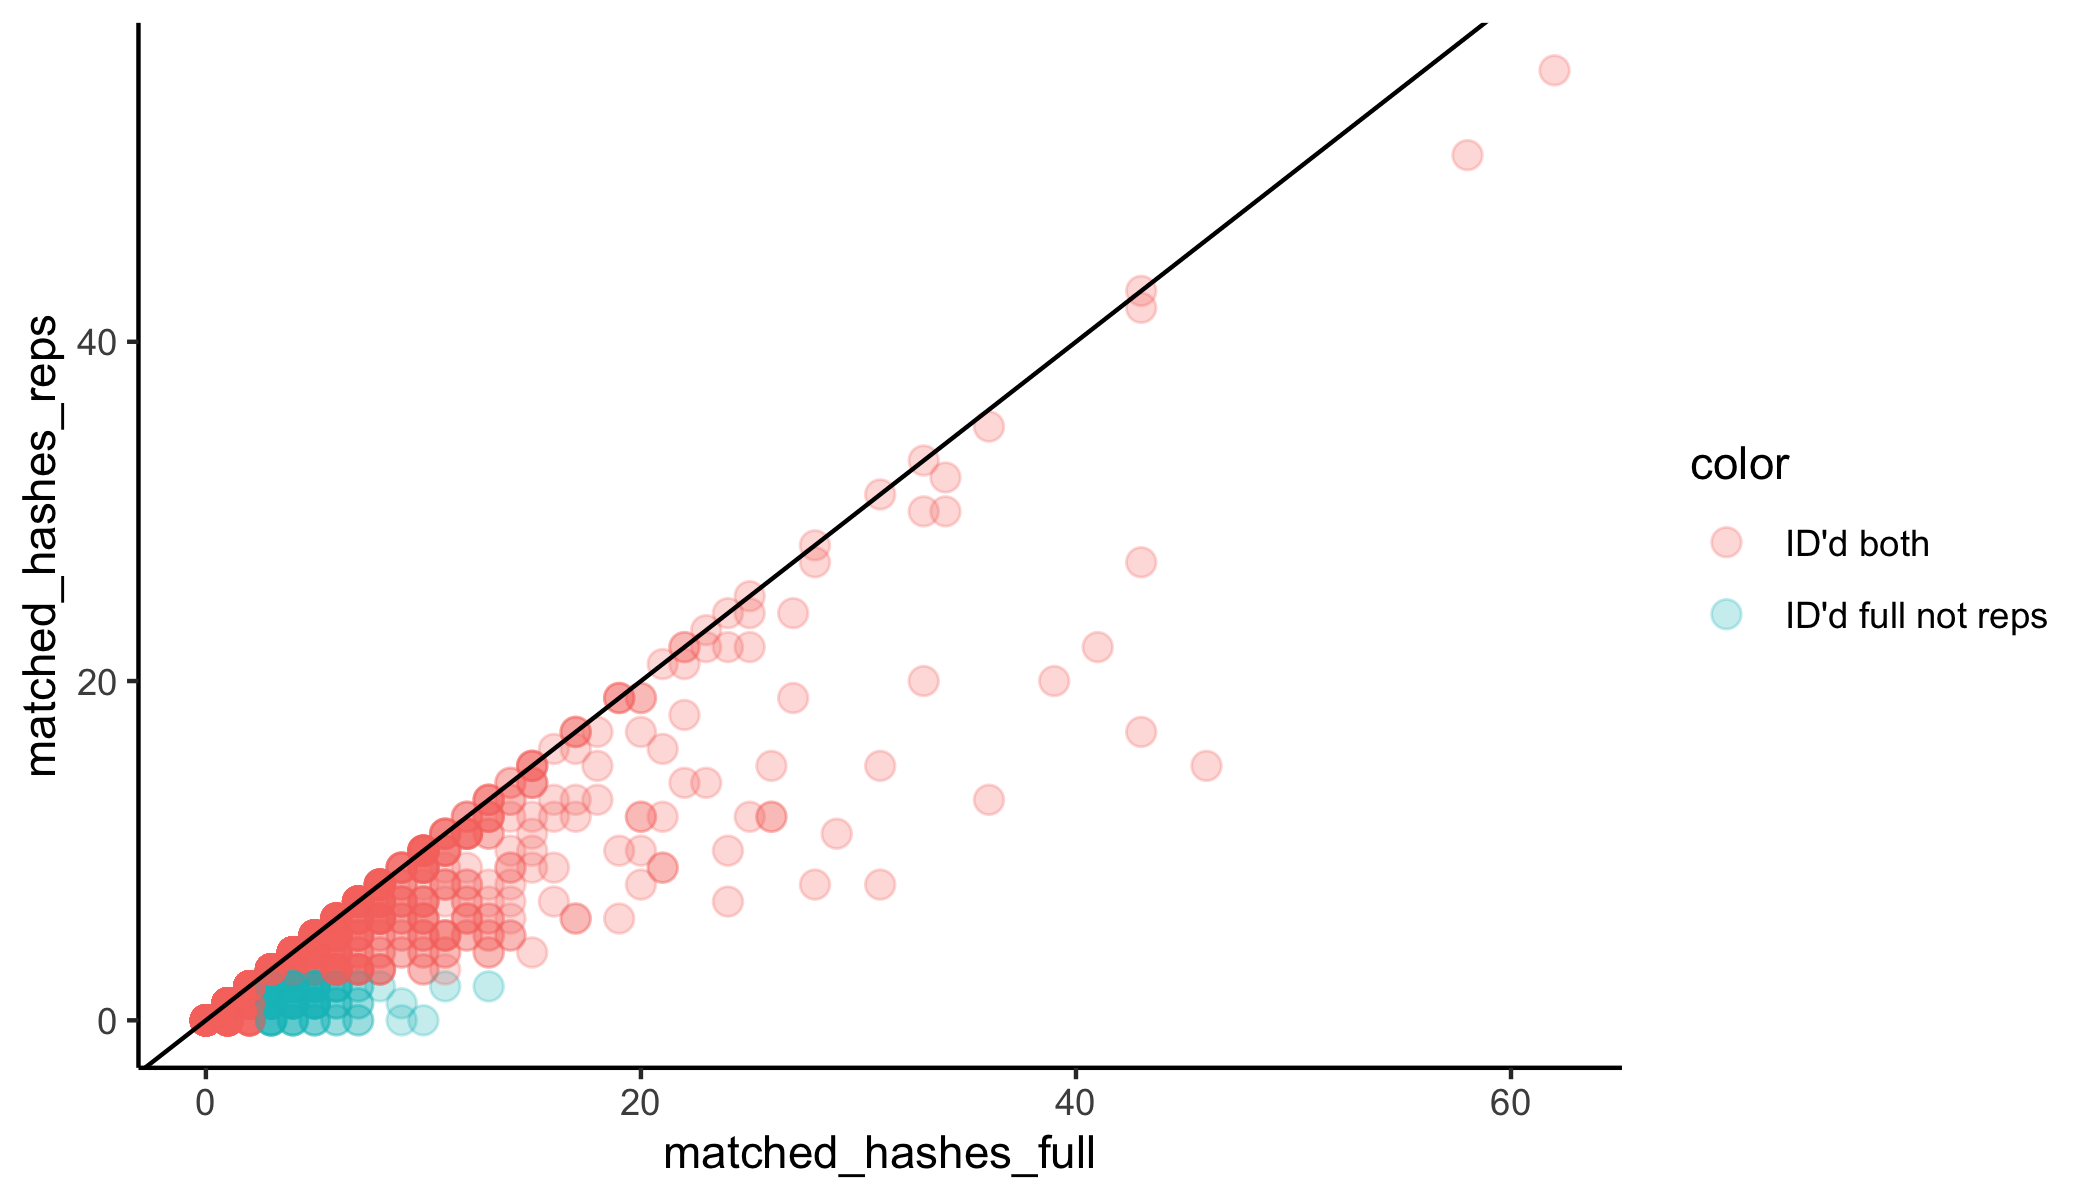

In [23]:
contig_ex <- contig_ex %>%
  mutate(color = ifelse(matched_hashes_reps < 3 & matched_hashes_full >=3, "ID'd full not reps", "ID'd both"))

ggplot(contig_ex, aes(x = matched_hashes_full, y = matched_hashes_reps, color = color)) +
  geom_point(size = 3, alpha = .25) +
  theme_classic() +
  geom_abline(intercept = 0, slope = 1)
  #scale_y_log10() + scale_x_log10()

### apply all and make sure sums to 1088

In [24]:
rs207_full_contig <- Sys.glob("sandbox/gunc_synthetic_genomes3b/type3b.genomes/outputs/genomes_to_charcoal3_vs_gtdb_rs207_full/stage1/*.contigs-tax.json") %>%
  map_dfr(read_contigs_tax)

In [25]:
rs207_rep_contig <- Sys.glob("sandbox/gunc_synthetic_genomes3b/type3b.genomes/outputs/genomes_to_charcoal3_vs_gtdb_rs207_reps/stage1/*.contigs-tax.json") %>%
  map_dfr(read_contigs_tax) 

In [29]:
contig_ex <- left_join(rs207_full_contig, rs207_rep_contig, by = c("genome", "contig_name", "basepairs", "hashes")) %>%
  select(genome, contig_name, basepairs, hashes,
         matched_hashes_full = matched_hashes.x, matched_hashes_reps = matched_hashes.y,
         lineage_full = lineage.x, lineage_reps = lineage.y) %>%
  mutate(matched_hashes_full = ifelse(is.na(matched_hashes_full), 0, matched_hashes_full),
         matched_hashes_reps = ifelse(is.na(matched_hashes_reps), 0, matched_hashes_reps)) %>%
  mutate(genome = gsub("_\\.fa", "", genome))

In [31]:
contig_ex <- contig_ex %>%
  mutate(color = ifelse(matched_hashes_reps < 3 & matched_hashes_full >=3, "ID'd full not reps", "ID'd both"))

In [46]:
contig_ex_phylum_contam_dirty <- contig_ex %>%
 filter(genome %in% faidx_phylum_contam_dirty$genome)

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”


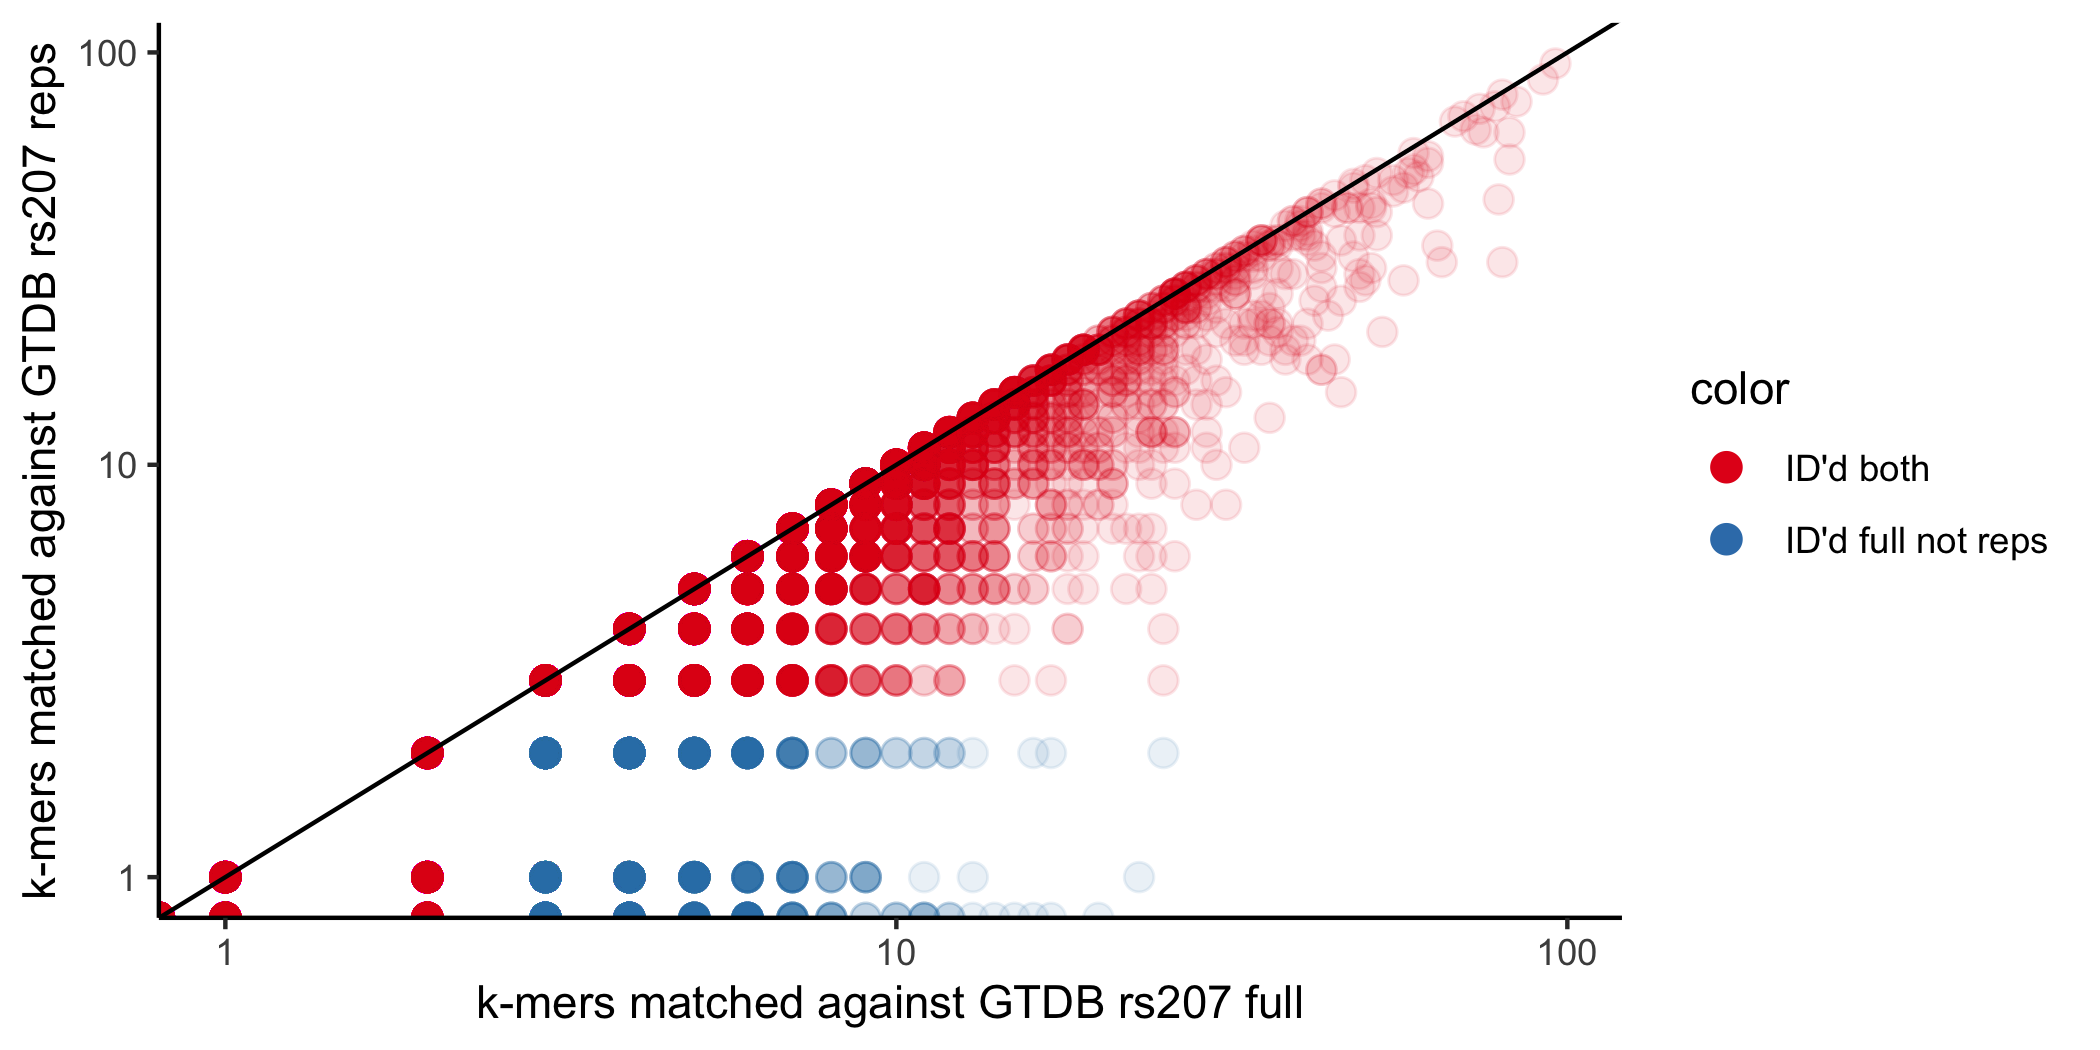

In [54]:
# change default figure size
options(repr.plot.width=7, repr.plot.height=3.5, repr.plot.res = 300)

ggplot(contig_ex_phylum_contam_dirty, aes(x = matched_hashes_full, y = matched_hashes_reps, color = color)) +
  geom_point(size = 3, alpha = .1) +
  theme_classic() +
  geom_abline(intercept = 0, slope = 1) +
  scale_y_log10() + scale_x_log10() +
  labs(x = "k-mers matched against GTDB rs207 full", 
       y = "k-mers matched against GTDB rs207 reps") + 
  scale_color_brewer(palette = "Set1") +
  guides(colour = guide_legend(override.aes = list(alpha = 1)))


In [48]:
table(contig_ex_phylum_contam_dirty$color)


         ID'd both ID'd full not reps 
              9764               1226 